# Multivariate Linear Regression based Global Mean Sea Level Forecasting

[Jianwu Wang @ UMBC](https://bdal.umbc.edu/people/jianwu/)

Nov 2022

This notebook demonstrates a machine learning based forecasting of Reconstructed Global Mean Sea Level data 1900-2018 (https://opendap.jpl.nasa.gov/opendap/allData/homage/L4/gmsl/global_timeseries_measures.nc). Additioinal information of the dataset can be found at https://podaac.jpl.nasa.gov/dataset/JPL_RECON_GMSL.

The notebook is an extention of https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb which provides detailed information on how to process Global Mean Sea Level data at AWS cloud. 

Please try notebook https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb to get inital evnronment setup first. Below are steps to run the EC2 instance is stopped and started again.


1.   Accessing your EC2 instance via ssh forwarding: 
```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@The_public_ip_address -L 9889:localhost:9889
```
2.   Activate jupyter environment via Conda
```
source ~/conda/bin/activate && \
conda activate jupyter && \
```
3.   Start jupyter via command line
```
W="$(python3 -c 'from notebook.auth import passwd; import getpass; print(passwd(getpass.getpass(), algorithm="sha256"))')"
jupyter lab --port=9889 --ip='127.0.0.1' --NotebookApp.token='' --NotebookApp.password="$PW" --notebook-dir="$HOME" --no-browser
```
4.  Access the server through your web browser: http://127.0.0.1:9889/ 




## Data preparation

In [1]:
#install via conda: conda sklearn pandas_profiling -y
import xarray as xr
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
#import pandas_profiling
from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [3]:
d1=xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/homage/L4/gmsl/global_timeseries_measures.nc')
print(d1)

<xarray.Dataset>
Dimensions:                                             (time: 119)
Coordinates:
  * time                                                (time) datetime64[ns] ...
Data variables: (12/21)
    global_average_sea_level_change                     (time) float32 ...
    global_average_sea_level_change_upper               (time) float32 ...
    global_average_sea_level_change_lower               (time) float32 ...
    glac_mean                                           (time) float32 ...
    glac_upper                                          (time) float32 ...
    glac_lower                                          (time) float32 ...
    ...                                                  ...
    global_average_thermosteric_sea_level_change        (time) float32 ...
    global_average_thermosteric_sea_level_change_upper  (time) float32 ...
    global_average_thermosteric_sea_level_change_lower  (time) float32 ...
    sum_of_contrib_processes_mean                       (tim

In [13]:
df = d1.to_dataframe()
#df = df.drop(columns=['time'])
#df.columns.values
df

,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,AIS_lower,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower
time,,,,,,,,,,,,,,,,,,,,,
1900-06-15,-173.261398,-141.002808,-203.557297,-79.553703,-62.500000,-95.500000,-48.064430,-37.400002,-58.799999,-9.494853,...,-16.15,12.326830,21.799999,2.80,-48.279350,-37.552921,-58.666309,-173.090805,-146.755402,-199.227905
1901-06-15,-168.801697,-135.897598,-201.018494,-78.703812,-61.799999,-94.599998,-48.179390,-37.599998,-58.950001,-9.440325,...,-16.00,15.246700,24.700001,5.75,-49.144901,-38.849602,-58.755150,-170.245499,-144.462402,-195.460800
1902-06-15,-180.389999,-148.213806,-212.074097,-77.843643,-61.200001,-93.500000,-47.861698,-37.450001,-58.650002,-9.385606,...,-15.90,16.570810,26.100000,7.15,-49.877560,-39.888828,-59.155022,-168.421799,-142.791702,-193.369797
1903-06-15,-170.267807,-138.930496,-202.697601,-77.272087,-60.549999,-92.849998,-47.453548,-36.950001,-58.200001,-9.331830,...,-15.80,16.624290,26.100000,7.15,-51.100590,-40.815861,-60.985008,-168.557602,-143.225800,-193.189896
1904-06-15,-168.720093,-137.450104,-200.167007,-76.430740,-59.799999,-91.800003,-46.626560,-37.400002,-56.200001,-9.277636,...,-15.65,16.227051,25.700001,6.70,-52.240181,-41.379250,-62.585709,-168.372406,-142.754593,-193.112198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-15,11.868940,20.258060,3.502924,2.607803,2.800000,2.450000,3.849548,4.050000,3.700000,1.770051,...,1.40,-0.759097,-0.050000,-1.60,4.670032,5.028707,4.308544,12.164770,13.248380,10.868380
2015-06-15,17.869520,26.591749,9.216259,3.392661,3.650000,3.200000,4.429987,4.700000,4.200000,2.701558,...,2.20,3.344095,4.250000,2.30,6.744699,7.239516,5.933526,20.688690,22.158630,18.938299
2016-06-15,23.941860,32.672989,15.510550,4.098025,4.350000,3.850000,5.181757,5.500000,4.950000,2.511931,...,1.90,4.953524,6.000000,3.65,6.472463,7.420359,5.686140,23.292170,25.237761,21.122080


In [14]:
df.loc[:, 'global_average_sea_level_change_2'] = df['global_average_sea_level_change']
df

,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower,global_average_sea_level_change_2
time,,,,,,,,,,,,,,,,,,,,,
1900-06-15,-173.261398,-141.002808,-203.557297,-79.553703,-62.500000,-95.500000,-48.064430,-37.400002,-58.799999,-9.494853,...,12.326830,21.799999,2.80,-48.279350,-37.552921,-58.666309,-173.090805,-146.755402,-199.227905,-173.261398
1901-06-15,-168.801697,-135.897598,-201.018494,-78.703812,-61.799999,-94.599998,-48.179390,-37.599998,-58.950001,-9.440325,...,15.246700,24.700001,5.75,-49.144901,-38.849602,-58.755150,-170.245499,-144.462402,-195.460800,-168.801697
1902-06-15,-180.389999,-148.213806,-212.074097,-77.843643,-61.200001,-93.500000,-47.861698,-37.450001,-58.650002,-9.385606,...,16.570810,26.100000,7.15,-49.877560,-39.888828,-59.155022,-168.421799,-142.791702,-193.369797,-180.389999
1903-06-15,-170.267807,-138.930496,-202.697601,-77.272087,-60.549999,-92.849998,-47.453548,-36.950001,-58.200001,-9.331830,...,16.624290,26.100000,7.15,-51.100590,-40.815861,-60.985008,-168.557602,-143.225800,-193.189896,-170.267807
1904-06-15,-168.720093,-137.450104,-200.167007,-76.430740,-59.799999,-91.800003,-46.626560,-37.400002,-56.200001,-9.277636,...,16.227051,25.700001,6.70,-52.240181,-41.379250,-62.585709,-168.372406,-142.754593,-193.112198,-168.720093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-15,11.868940,20.258060,3.502924,2.607803,2.800000,2.450000,3.849548,4.050000,3.700000,1.770051,...,-0.759097,-0.050000,-1.60,4.670032,5.028707,4.308544,12.164770,13.248380,10.868380,11.868940
2015-06-15,17.869520,26.591749,9.216259,3.392661,3.650000,3.200000,4.429987,4.700000,4.200000,2.701558,...,3.344095,4.250000,2.30,6.744699,7.239516,5.933526,20.688690,22.158630,18.938299,17.869520
2016-06-15,23.941860,32.672989,15.510550,4.098025,4.350000,3.850000,5.181757,5.500000,4.950000,2.511931,...,4.953524,6.000000,3.65,6.472463,7.420359,5.686140,23.292170,25.237761,21.122080,23.941860


In [15]:
#Creating datasets with lag of 1 to 6 months
df1 = df.assign(global_average_sea_level_change_2 = df.global_average_sea_level_change_2.shift(-1)).drop(df.index[-1])
df2 = df1.assign(global_average_sea_level_change_2 = df1.global_average_sea_level_change_2.shift(-1)).drop(df1.index[-1])
df3 = df2.assign(global_average_sea_level_change_2 = df2.global_average_sea_level_change_2.shift(-1)).drop(df2.index[-1])
df4 = df3.assign(global_average_sea_level_change_2 = df3.global_average_sea_level_change_2.shift(-1)).drop(df3.index[-1])
df5 = df4.assign(global_average_sea_level_change_2 = df4.global_average_sea_level_change_2.shift(-1)).drop(df4.index[-1])
df6 = df5.assign(global_average_sea_level_change_2 = df5.global_average_sea_level_change_2.shift(-1)).drop(df5.index[-1])

## Model training based on 1 month lag data

In [16]:
df1

,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower,global_average_sea_level_change_2
time,,,,,,,,,,,,,,,,,,,,,
1900-06-15,-173.261398,-141.002808,-203.557297,-79.553703,-62.500000,-95.500000,-48.064430,-37.400002,-58.799999,-9.494853,...,12.326830,21.799999,2.80,-48.279350,-37.552921,-58.666309,-173.090805,-146.755402,-199.227905,-168.801697
1901-06-15,-168.801697,-135.897598,-201.018494,-78.703812,-61.799999,-94.599998,-48.179390,-37.599998,-58.950001,-9.440325,...,15.246700,24.700001,5.75,-49.144901,-38.849602,-58.755150,-170.245499,-144.462402,-195.460800,-180.389999
1902-06-15,-180.389999,-148.213806,-212.074097,-77.843643,-61.200001,-93.500000,-47.861698,-37.450001,-58.650002,-9.385606,...,16.570810,26.100000,7.15,-49.877560,-39.888828,-59.155022,-168.421799,-142.791702,-193.369797,-170.267807
1903-06-15,-170.267807,-138.930496,-202.697601,-77.272087,-60.549999,-92.849998,-47.453548,-36.950001,-58.200001,-9.331830,...,16.624290,26.100000,7.15,-51.100590,-40.815861,-60.985008,-168.557602,-143.225800,-193.189896,-168.720093
1904-06-15,-168.720093,-137.450104,-200.167007,-76.430740,-59.799999,-91.800003,-46.626560,-37.400002,-56.200001,-9.277636,...,16.227051,25.700001,6.70,-52.240181,-41.379250,-62.585709,-168.372406,-142.754593,-193.112198,-160.981400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-15,6.370174,14.942650,-2.195722,1.867449,2.050000,1.700000,3.443771,3.600000,3.350000,1.079971,...,0.398772,0.900000,-0.15,3.112605,3.669379,2.740455,9.972470,10.931610,8.955513,11.868940
2014-06-15,11.868940,20.258060,3.502924,2.607803,2.800000,2.450000,3.849548,4.050000,3.700000,1.770051,...,-0.759097,-0.050000,-1.60,4.670032,5.028707,4.308544,12.164770,13.248380,10.868380,17.869520
2015-06-15,17.869520,26.591749,9.216259,3.392661,3.650000,3.200000,4.429987,4.700000,4.200000,2.701558,...,3.344095,4.250000,2.30,6.744699,7.239516,5.933526,20.688690,22.158630,18.938299,23.941860


In [17]:
data = np.array(df1)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing



x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]



In [18]:
# x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,) # .target.reshape(-1, 1)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88, 21)
(88,)
(30, 21)
(30,)


In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train) 
x_test = scaler_x.transform(x_test) 

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1)) 

In [21]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [22]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

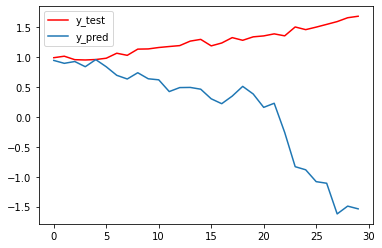

In [23]:
%matplotlib inline
#plot 
plt.plot(y_test, color='red')
plt.plot(y_pred)

plt.legend(['y_test','y_pred'])
plt.show()


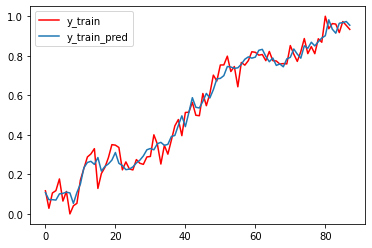

In [24]:
%matplotlib inline
#plot 
plt.plot(y_train, color='red')
plt.plot(y_train_pred)

plt.legend(['y_train','y_train_pred'])
plt.show()

In [25]:
#Sample code to inverse transform data
#Inverse transformation should be performed after getting predictions
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [26]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag1.npy', inv_y_pred)
_ = np_file.seek(0)

In [27]:
rmse1 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse1

197.2281

In [28]:
nrmse1 = rmse1/(np.mean(inv_y_test))
nrmse1

-9.873426

In [29]:
r2_score1 = r2_score(inv_y_test, inv_y_pred)

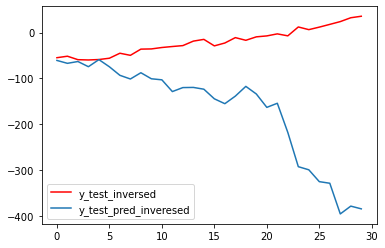

In [30]:
%matplotlib inline
#plot 
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)

plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()

## Model training based on 2 month lag data

In [31]:
data = np.array(df2)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [32]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(87, 21)
(87,)
(30, 21)
(30,)


In [33]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [34]:
model = LinearRegression()
model.fit(x_train, y_train) 

LinearRegression()

In [35]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

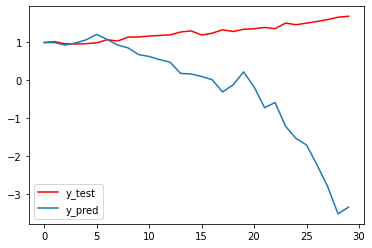

In [36]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

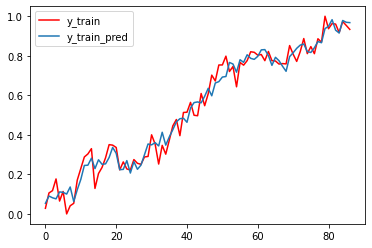

In [37]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [38]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [39]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag2.npy', inv_y_pred)
_ = np_file.seek(0)

In [40]:
rmse2 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))

In [41]:
nrmse2 = rmse2/(np.mean(inv_y_test))
nrmse2

-13.926745

In [42]:
r2_score2 = r2_score(inv_y_test, inv_y_pred)

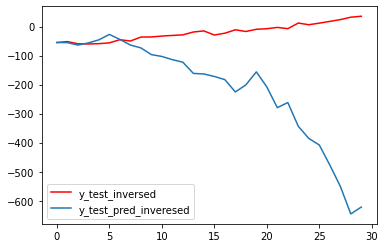

In [43]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## Model training based on 3 month lag data

In [44]:
data = np.array(df3)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [45]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(86, 21)
(86,)
(30, 21)
(30,)


In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [47]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [48]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

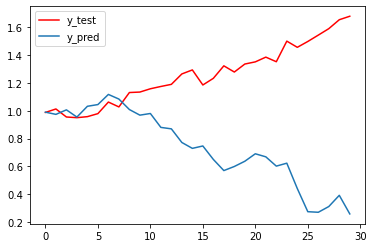

In [49]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

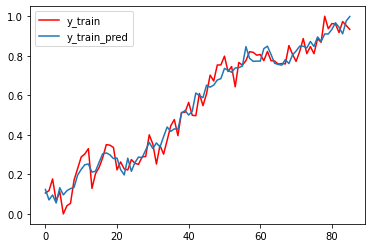

In [50]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [51]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.11773515]
[-168.7201]


In [52]:
#Save Test data vs predictions
from tempfile import TemporaryFile

np_file = TemporaryFile()
np.save('MLR_lag3.npy', inv_y_pred)
_ = np_file.seek(0)

In [53]:
rmse3 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse3

91.29984

In [54]:
nrmse3 = rmse3/(np.mean(inv_y_test))
nrmse3

-4.570557

In [55]:
r2_score3 = r2_score(inv_y_test, inv_y_pred)

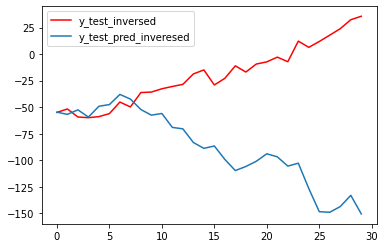

In [56]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## Model training based on 4 month lag data:

In [57]:
data = np.array(df4)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [58]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(85, 21)
(85,)
(30, 21)
(30,)


In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [60]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [61]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

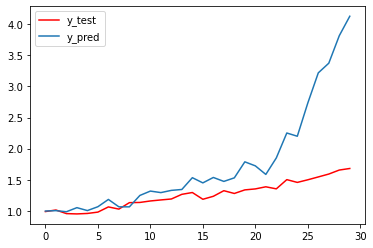

In [62]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

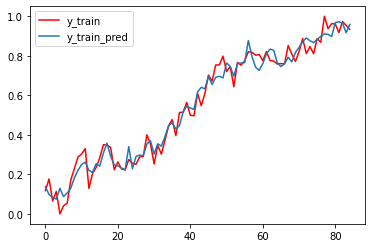

In [63]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [64]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [65]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag4.npy', inv_y_pred)
_ = np_file.seek(0)

In [66]:
rmse4 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse4

107.61852

In [67]:
nrmse4 = rmse4/(np.mean(inv_y_test))
nrmse4

-5.3874855

In [68]:
r2_score4 = r2_score(inv_y_test, inv_y_pred)

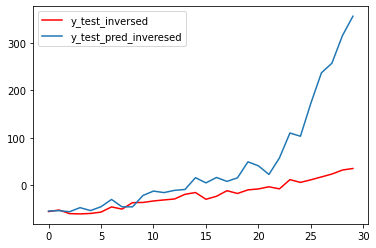

In [69]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## Model training based on 5 month lag data:

In [70]:
data = np.array(df5)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [71]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(84, 21)
(84,)
(30, 21)
(30,)


In [72]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [73]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [74]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

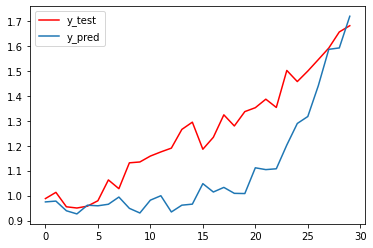

In [75]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

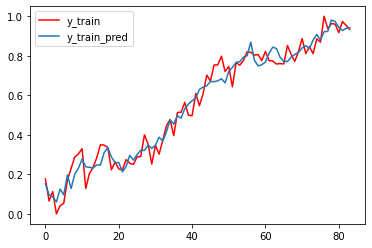

In [76]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [77]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.06507087]
[-175.6053]


In [78]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag5.npy', inv_y_pred)
_ = np_file.seek(0)

In [79]:
rmse5 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse5

25.18915

In [80]:
nrmse5 = rmse5/(np.mean(inv_y_test))
nrmse5

-1.2609928

In [81]:
r2_score5 = r2_score(inv_y_test, inv_y_pred)

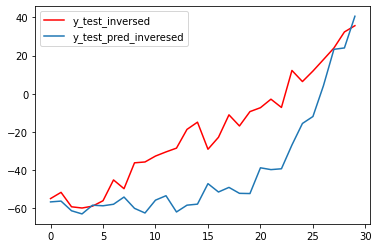

In [82]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## Model training based on 6 month lag data:

In [83]:
data = np.array(df6)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [84]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(83, 21)
(83,)
(30, 21)
(30,)


In [85]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [86]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [87]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

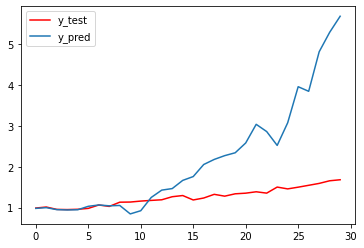

In [88]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

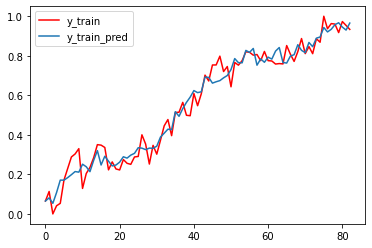

In [89]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [90]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.11353517]
[-169.2692]


In [91]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag6.npy', inv_y_pred)
_ = np_file.seek(0)

In [92]:
rmse6 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse6

192.87285

In [93]:
nrmse6 = rmse6/(np.mean(inv_y_test))
nrmse6

-9.655398

In [94]:
r2_score6 = r2_score(inv_y_test, inv_y_pred)

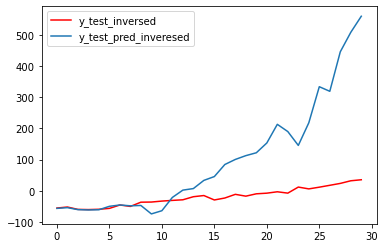

In [95]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## Model performance comparison

In [96]:
print(rmse1, rmse2, rmse3, rmse4, rmse5, rmse6)

197.2281 278.19577 91.29984 107.61852 25.18915 192.87285


In [97]:
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6]
rmse

[197.2281, 278.19577, 91.29984, 107.61852, 25.18915, 192.87285]

In [98]:
nrmse = [nrmse1, nrmse2, nrmse3, nrmse4, nrmse5, nrmse6]
nrmse

[-9.873426, -13.926745, -4.570557, -5.3874855, -1.2609928, -9.655398]

In [99]:
r2 = [r2_score1, r2_score2, r2_score3, r2_score4, r2_score5, r2_score6]
r2

[-48.805371907537165,
 -98.09225176913446,
 -9.672807294663253,
 -13.829028059112796,
 0.1876078956600905,
 -46.63002987439784]

### The above comparison shows using 5 month lag data achieves the best performance.